# Домашнее задание 3 по численным методам.

# 1

![image.png](attachment:3a5de9ea-1844-4986-872f-fe9133d42984.png)

К моему огромному сожалению, в исследовании на устойчивость я где-то намудрил и не смог найти ошибку. Идея такова:
1) Воспользоваться имеющимся уравнением без $y_{ij}^{n+1/2}$
2) По критерию Неймана начать искать решение такого уравнения в виде $u_n^k = \lambda^k e^{i\alpha x} e^{i\beta y}$
3) Выразить $\lambda$

Скорее всего, для $\forall \ \alpha \ \beta$ $|\lambda|$ окажется $\leqslant 1$

# 2

## Постановка задачи

Уравнение теплопроводности. Решить продольно-поперечным методом начально-краевую задачу для двумерного уравнения теплопроводности:

$$
\begin{array}{l}
u_t = 2(u_{xx} + u_{yy}) + e^t\cos\dfrac{\pi x}{2}\sin\dfrac{\pi y}{2}, \; x \in [0;1], \; y \in [0;1], \; t > 0,\\
\left.u\right|_{t = 0} = 1 + xy,\\
\left.u\right|_{x = 0} = 1 + \dfrac{\left(e^t - e^{-\pi^2 t}\right)}{1 + \pi^2}\sin\dfrac{\pi y}{2}, \; &\left.u\right|_{x = 1} = 1 + y, \\
\left.u\right|_{y = 0} = 1, \; &\left.u\right|_{y = 1} = 1 + x + \dfrac{\left(e^t - e^{-\pi^2 t}\right)}{1 + \pi^2}\cos\dfrac{\pi x}{2}, \\
\end{array}
$$

## Сетка

Для решения задачи зададим равномерную сетку размером $(N+1)\times(N+1)$, пространственный шаг по обеим осям будет равен $\dfrac{1}{N}$. Также дополнительно будем задавать некоторый временной промежуток для вычисления (ибо процесс не стационарен), откуда возьмём временной шаг как $\dfrac{1}{N\_timings}$

## Продольно-поперечная схема

Уравнения схемы:
$$
\dfrac{u^{1/2}_{n,m} - u_{n,m}}{\tau/2} = D\left(\dfrac{u^{1/2}_{n-1,m} - 2u^{1/2}_{n,m} + u^{1/2}_{n+1,m}}{h^2} + \dfrac{u^{1/2}_{n,m-1} - 2u^{1/2}_{n,m} + u^{1/2}_{n,m+1}}{h^2}\right) + f(x,y,t) \\
\dfrac{\hat u_{n,m} - u^{1/2}_{n,m}}{\tau/2} = D\left(\dfrac{u^{1/2}_{n-1,m} - 2u^{1/2}_{n,m} + u^{1/2}_{n+1,m}}{h^2} + \dfrac{\hat u_{n,m-1} - 2\hat u_{n,m} + \hat u_{n,m+1}}{h^2}\right) + f(x,y,t)
$$

где $f(x,y,t) = e^t\cos\dfrac{\pi x}{2}\sin\dfrac{\pi y}{2}$

Здесь верхний индекс $1/2$ обозначает дополнительный -- промежуточный -- слой, отсчитывающийся от нынешнего. Такая схема будет одновременно и явной, и неявной.

Сначала решим первое уравнение, зафиксировав $m$: получим систему уравнений, решая которую получим значения по сетке в $m$-том ряду. Проитерируясь по всем $m$, получим искомые значения на промежуточном слое. Значения в краевых условиях можно подтянуть, если вычесть из второго уравнения первое.

Таким образом, мы получили промежуточный слой, от которого теперь сможем отталкиваться по такой же схеме, только теперь фиксируя другую переменную, получая $n$-тую колонку.

In [ ]:
import numpy as np
import matplotlib
from scipy.linalg import solve_banded
from matplotlib import pyplot as plt

In [ ]:
# Initials and boundaries

f = lambda x, y, t: np.exp(t)*np.cos(np.pi*x/2)*np.sin(np.pi*y/2)

ut0 = lambda x, y: 1 + x*y

ux0 = lambda y, t: 1 + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2)*np.sin(np.pi * y/2)

ux1 = lambda y: 1 + y

uy0 = 1

uy1 = lambda x, t: 1 + x + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2)*np.cos(np.pi * x/2)

In [ ]:
# Additional function to make code not so difficult to read

def fill_half_layer(half_u, prev_u, curr_u, h, tau):
    N = half_u.shape[0] - 1

    for i in range(1, N):
        nplus = curr_u[0,i+1] - prev_u[0, i+1]
        n = curr_u[0,i] - prev_u[0,i]
        nminus = curr_u[0, i-1] - prev_u[0, i-1]
        half_u[0,i] = (curr_u[0,i] + prev_u[0,i])/2 - tau/(4 * h**2) * (nplus - 2*n + nminus)

        nplus = curr_u[N,i+1] - prev_u[N, i+1]
        n = curr_u[N,i] - prev_u[N,i]
        nminus = curr_u[N, i-1] - prev_u[N, i-1]
        half_u[N,i] = (curr_u[N,i] + prev_u[N,i])/2 - tau/(4 * h**2) * (nplus - 2*n + nminus)

    return half_u

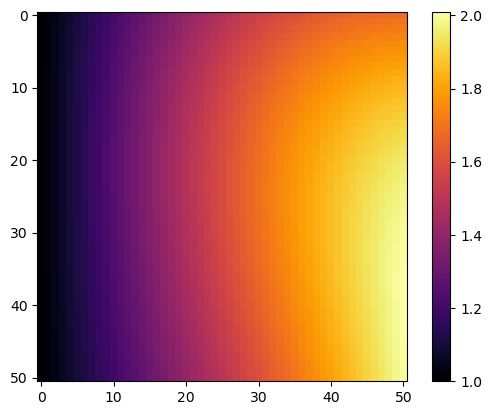

In [ ]:
N = 50
x_grid, h = np.linspace(0, 1, N+1, retstep=True)
y_grid = np.linspace(0, 1, N+1)

N_timings = 1000
t_grid, tau = np.linspace(0, 2, N_timings + 1, retstep=True)

current_u = np.zeros((N+1, N+1))

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        current_u[i,j] = ut0(x,y) # Fill everything when t=0

half_layer_u = np.zeros((N+1, N+1))
b = np.zeros(N-1)

A = np.zeros((3, N-1))
A[0, :] = -2/h**2
A[1, :] = 4/h**2 + 2/tau
A[2, :] = -2/h**2

for time in t_grid[:-1]:
    previous_u = current_u.copy() # Copy to save

    # All boundaries
    current_u = np.zeros((N+1, N+1))
    current_u[:, 0] = uy0
    current_u[:, -1] = uy1(x_grid, time+tau)
    current_u[0, 1:-1] = ux0(y_grid[1:-1], time+tau)
    current_u[-1, 1:-1] = ux1(y_grid[1:-1])

    half_layer_u = np.zeros((N+1, N+1))
    half_layer_u = fill_half_layer(half_layer_u, previous_u, current_u, h, tau)

    for i in range(1, N):
        b = 2 * (previous_u[1:-1, i+1] - 2*previous_u[1:-1, i] + previous_u[1:-1, i-1])/h**2 + 2*previous_u[1:-1, i]/tau + f(x_grid[1:-1], y_grid[i], time+tau/2)
        b[0] += 2*half_layer_u[0,i]/h**2
        b[-1] += 2*half_layer_u[-1,i]/h**2
        half_layer_u[1:-1, i] = solve_banded((1,1), A, b)

    for j in range(1, N):
        b = 2 * (half_layer_u[j+1, 1:-1] - 2*half_layer_u[j, 1:-1] + half_layer_u[j-1, 1:-1])/h**2 + 2*half_layer_u[j, 1:-1]/tau + f(x_grid[j], y_grid[1:-1], time+tau)
        b[0] += 2*current_u[j, 0]/h**2
        b[-1] += 2*current_u[j, -1]/h**2
        current_u[j, 1:-1] = solve_banded((1,1), A, b)


plt.imshow(current_u, cmap='inferno')
plt.colorbar()

Истинное решение данной задачи имеет вид:
$$
u = 1 + xy + \dfrac{\left(e^t - e^{-\pi^2 t}\right)}{1 + \pi^2}\cos\dfrac{\pi x}{2}\sin\dfrac{\pi y}{2}
$$

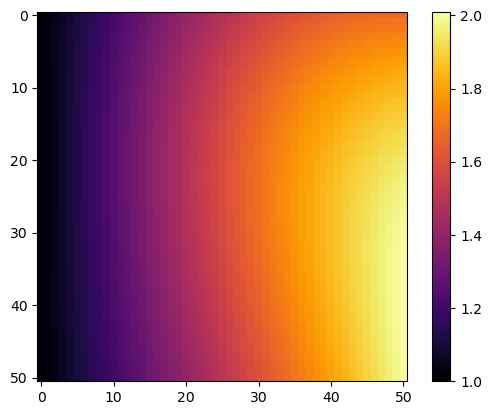

In [ ]:
true_solution = lambda x,y,t: 1 + x*y + (np.exp(t) - np.exp(-np.pi**2 * t))/(1 + np.pi**2)*np.cos(np.pi * x/2)*np.sin(np.pi * y/2)

true_u = [[true_solution(x_grid[i], y_grid[j], time + tau) for j in range(N+1)] for i in range(N+1)]

plt.imshow(np.array(true_u), cmap='inferno')
plt.colorbar()

Ошибка с посчитанным составила:

In [ ]:
np.linalg.norm(np.array(true_u) - current_u)

0.0019631565312528297

А здесь я хочу визуализировать места, где ошибка больше всего. Как можно видеть, она накапливается ближе к середине рисунка, что вполне объяснимо из-за наличия краевых условий, которые ошибку не дают

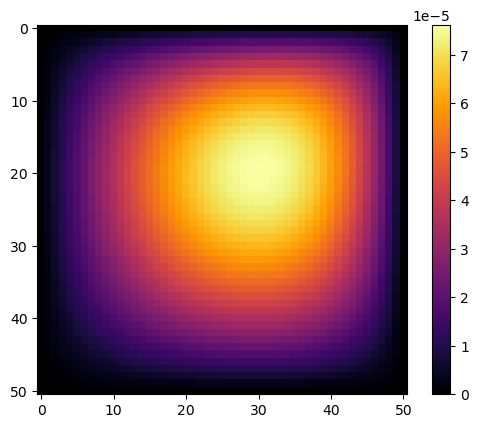

In [ ]:
plt.imshow(current_u - np.array(true_u), cmap='inferno')
plt.colorbar()